# Wine Quality

Dataset: https://archive.ics.uci.edu/dataset/186/wine+quality

### Description of features:

Input variables (based on physicochemical tests):

1. Fixed Acidity
2. Volatile Acidity
3. Citric Acid
4. Residual Sugar
5. Chlorides
6. Free Sulfur Dioxide
7. Total Sulfur Dioxide
8. Density
9. pH
10. Sulphates
11. Alcohol

Output variable (based on sensory data):

12. Quality: Score between 0 and 10

In [16]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, roc_curve, auc

In [17]:
data = pd.read_csv("./data/winequality-red.csv", sep=";")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Data Pre-Processing

In [18]:
# Check for missing data (none in wine dataset but hey)
print(data.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


There is no missing data for any of the features.

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


All features are of type float, meaning continuous, numerical values.

In [20]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<Axes: >

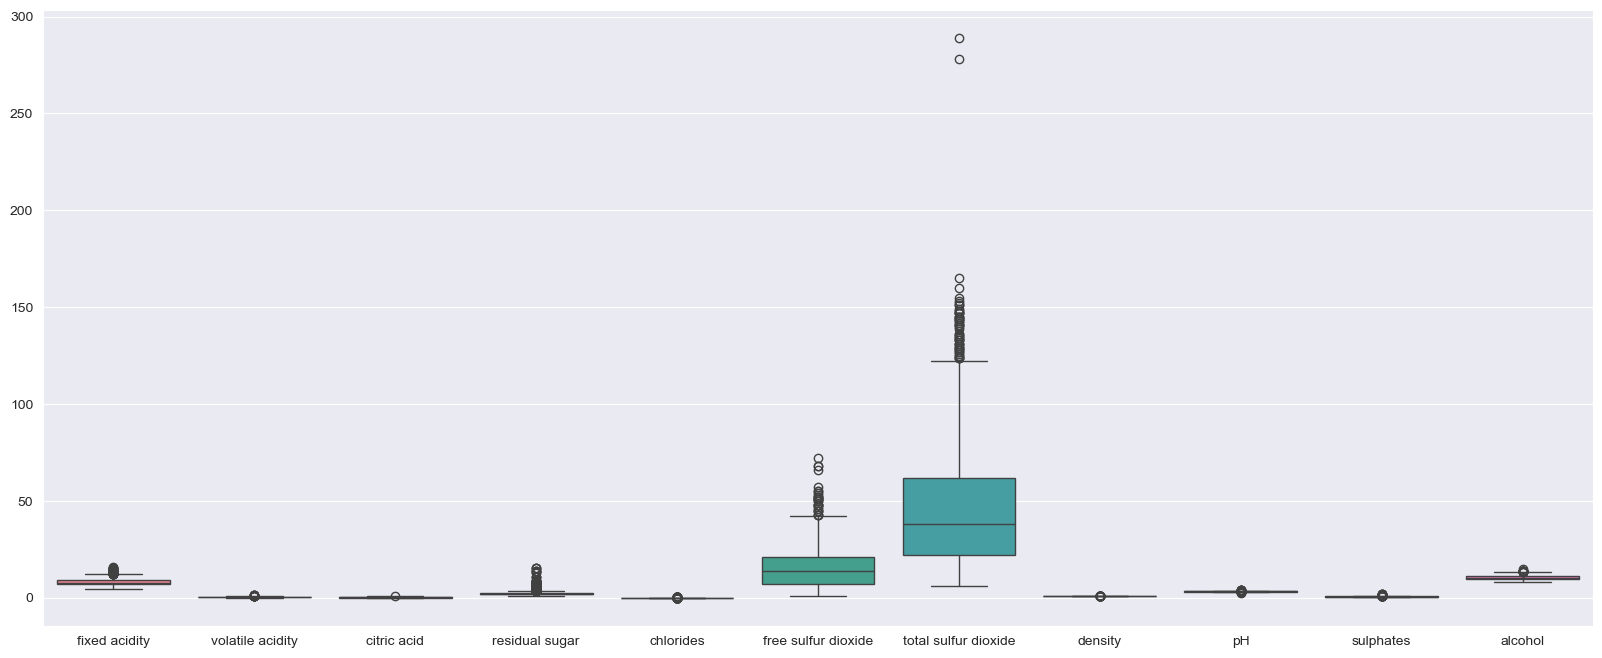

In [21]:
# Compare feature ranges for all features
fig, ax = plt.subplots(1, figsize=(20, 8))
sns.boxplot(data=data.iloc[:, 0:11], ax=ax)   

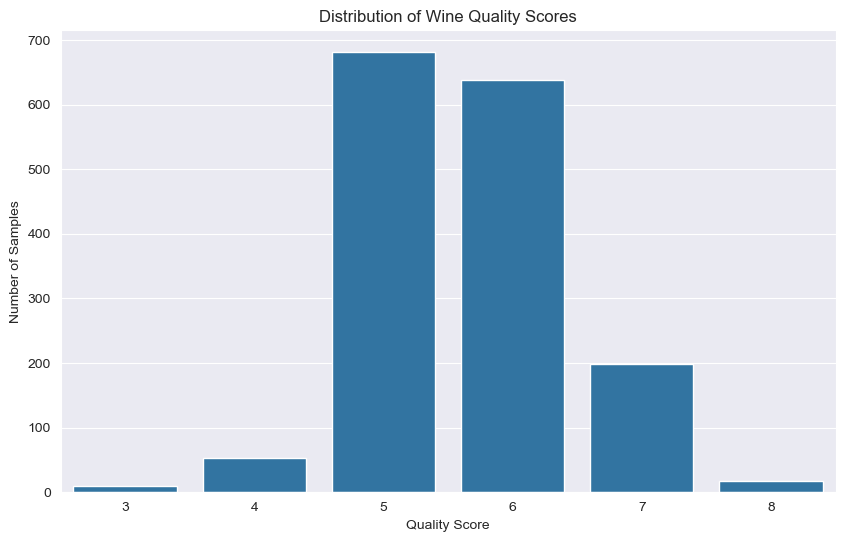

In [22]:
# Create a bar plot of the distribution of quality scores in the dataset

quality_counts = data['quality'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=quality_counts.index, y=quality_counts.values)
plt.title('Distribution of Wine Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Number of Samples')
plt.show()

As shown by the above bar chart, there is a lack of data on wines of qualities with very low and very high scores. Therefore, prediction of wine quality score would be limited to the range of scores in the dataset.

To reduce the scope of quality scores, we have classified the scores into 3 labels: Good, Middle, Bad.

In [23]:
data = data.replace({'quality' : {
                                    8 : 'Good',
                                    7 : 'Good',
                                    6 : 'Middle',
                                    5 : 'Middle',
                                    4 : 'Bad',
                                    3 : 'Bad',
        }}
)

Since, all the features have very different range of values, it is beneficial to use feature normalisation.

<Axes: >

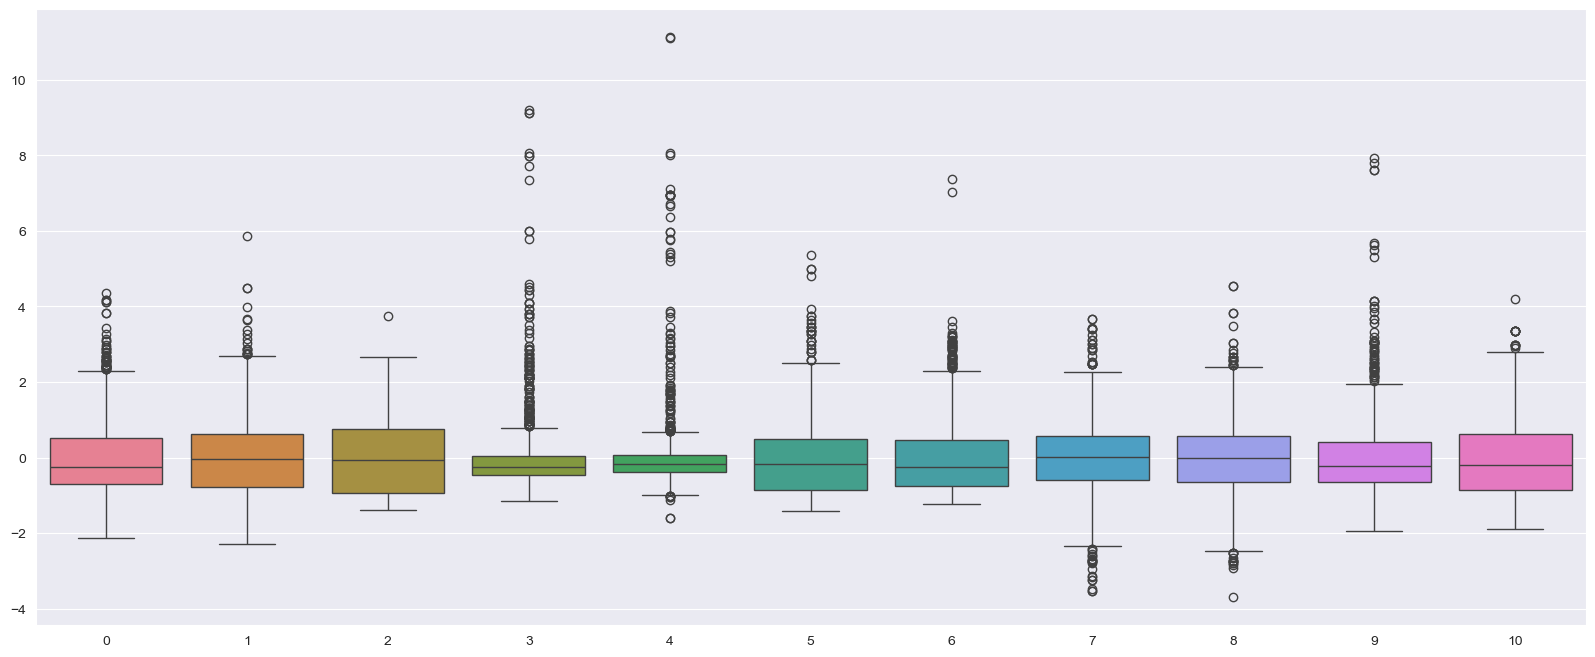

In [24]:
# Feature Normalisation

from sklearn.preprocessing import StandardScaler

X_temp = data.drop(columns='quality')
y = data.quality

scaler = StandardScaler()
X = scaler.fit_transform(X_temp)
fig, ax = plt.subplots(1, figsize=(20,8))
sns.boxplot(data = X, ax=ax)

### Logistic Regression

In [25]:
# Get numeric data from string
y_numeric = data['quality'].map({'Good': 2, 'Middle': 1, 'Bad': 0})

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.3, random_state=42)

In [28]:
regression_model = LogisticRegression()

regression_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_test_pred = regression_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test set performance (tuned):")
print(f"Model score: {regression_model.score(X_test, y_test)* 100:.2f}%")

Test set performance (tuned):
Model score: 82.71%


In [29]:
# Get predictions directly using the pipeline
y_pred_continuous = regression_model.predict_proba(X_test)[:, 1]

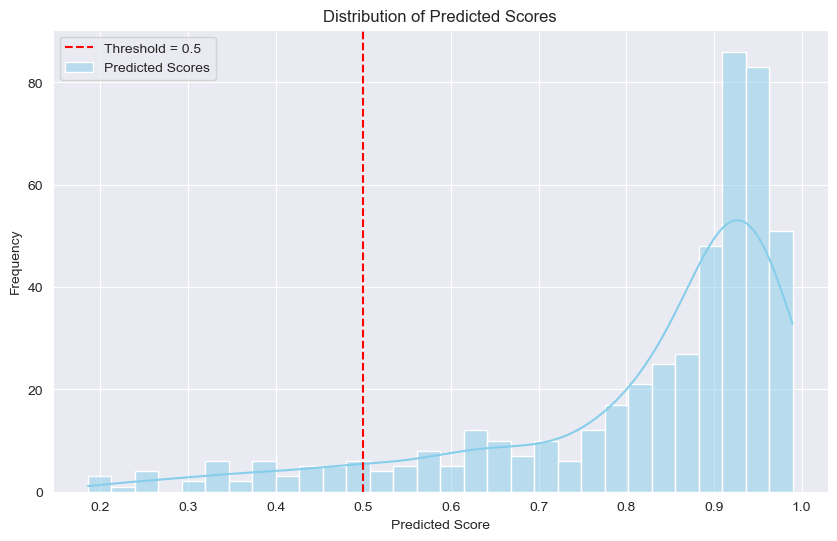

In [30]:
# Plot distribution of continuous predictions
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_continuous, kde=True, bins=30, color="skyblue", label="Predicted Scores")
plt.axvline(x=0.5, color='red', linestyle='--', label=f"Threshold = {0.5}")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Scores")
plt.legend()
plt.show()

### Support Vector Machine

In [31]:
# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [32]:
from sklearn.svm import SVC

# Fit the model on the training data
svm_clf = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', probability=True)
svm_clf.fit(X_train, y_train)

SVC(gamma='auto', probability=True)

In [33]:
# R^2 score
svc_score = round(svm_clf.score(X_test, y_test), 3)
print(f"SVC Score: {svc_score * 100:.2f}%")

SVC Score: 87.30%


### Decision Tree

Decision Tree Validation Accuracy: 83.75%


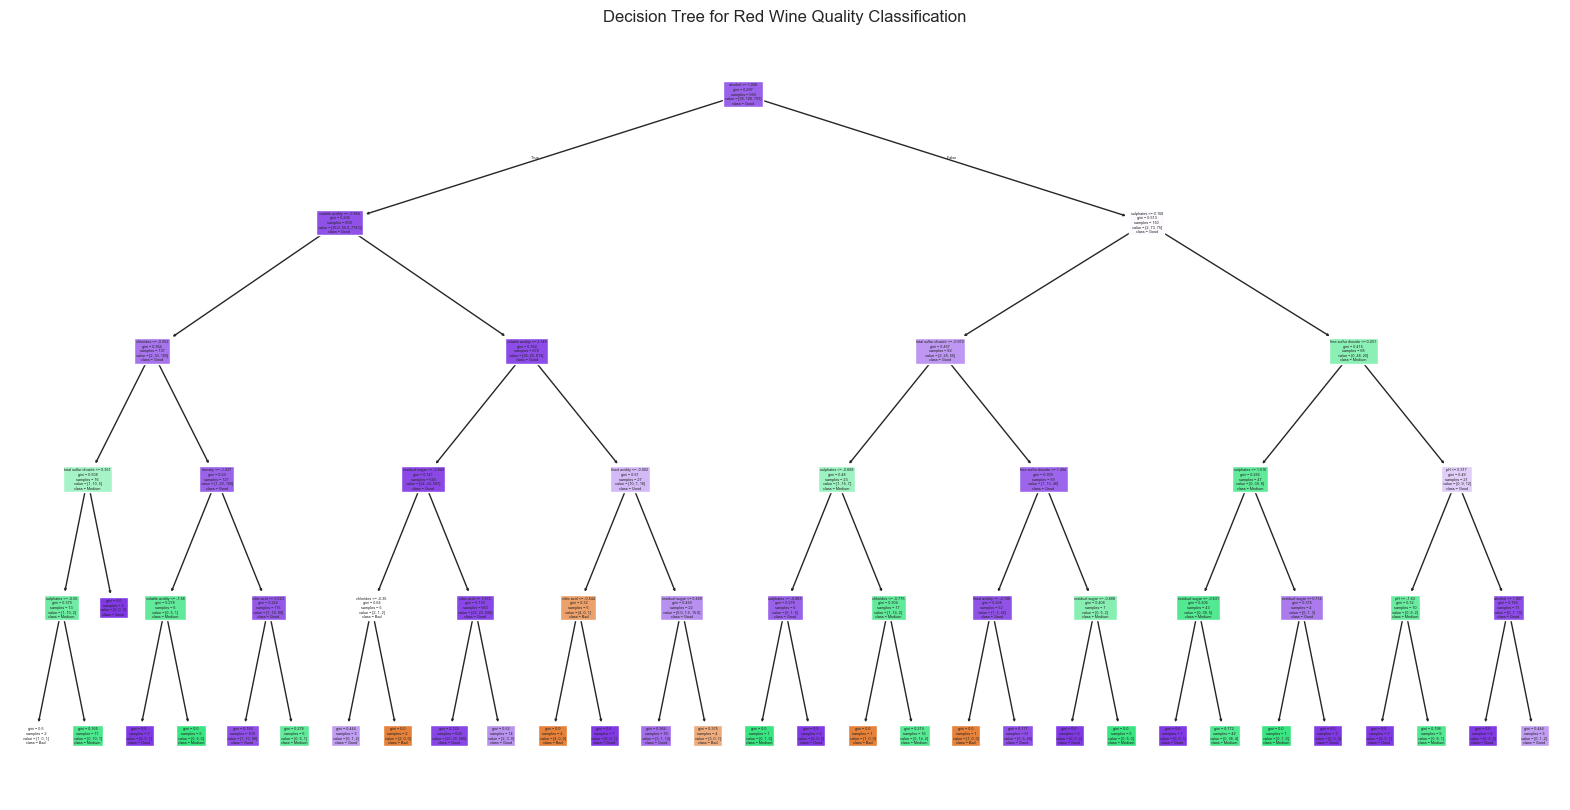

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the dataset into train, validation, and test sets
X_train, X_tempo, y_train, y_tempo = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tempo, y_tempo, test_size=0.5, random_state=42)

# Train the Decision Tree model
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict and calculate accuracy on the validation set
y_val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Decision Tree Validation Accuracy: {accuracy * 100:.2f}%")

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=data.columns[:-1], class_names=["Bad", "Medium", "Good"], filled=True)
plt.title("Decision Tree for Red Wine Quality Classification")
plt.show()


### Multi Layer Perceptron Neural Network

In [35]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.3, random_state=0)

mlp_clf = MLPClassifier(random_state=1, max_iter=1000, learning_rate_init=0.01, early_stopping=True)
mlp_clf.fit(X_train, y_train)
y_pred = mlp_clf.predict(X_test)
classifier_score = mlp_clf.score(X_test, y_test)

print(f"MLP Classifier Accuracy Score: {classifier_score * 100:.2f}%")

MLP Classifier Accuracy Score: 85.42%


### K-Fold Cross-validation

In [36]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

# Initialize models for classification tasks
models_classification = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'MLP': MLPClassifier(max_iter=1000, learning_rate_init=0.001, early_stopping=True)
}

# Split data
X_class = data.drop(columns='quality')
y_class = y

# Set up K-Fold cross-validation
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for name, model in models_classification.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scaling step
        ('model', model)               # Model step
    ])
    accuracy_scores = cross_val_score(pipeline, X_class, y_class, cv=skf, scoring='accuracy')
    print(f'{name} - Average Accuracy: {np.mean(accuracy_scores) * 100:.2f}%')


Logistic Regression - Average Accuracy: 84.37%
SVM - Average Accuracy: 85.05%
Decision Tree - Average Accuracy: 81.18%
MLP - Average Accuracy: 83.55%
